# Static cereal model

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 1. Create a rectangular leaf surface.

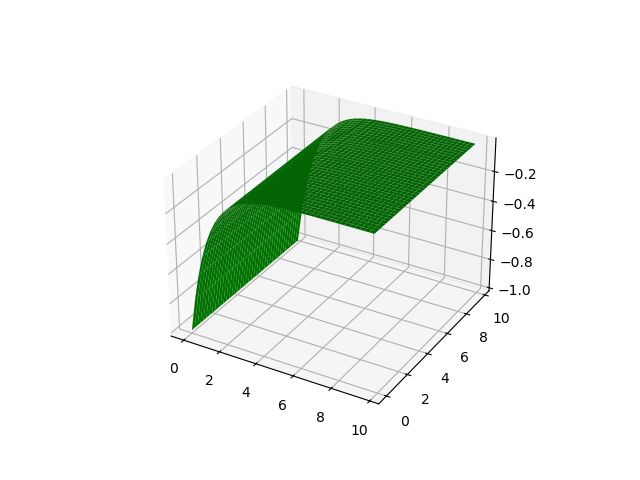

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Make data
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (1-np.exp(-X))

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, color="green")

plt.show()

## 2. Create a parametric leaf, with :

- x,y coordinates of points sampling a leaf midrib placed in a vertical plane (origin = leaf base)
- s,r parallel array for curviliear abcissa / relative leaf width along leaf shape

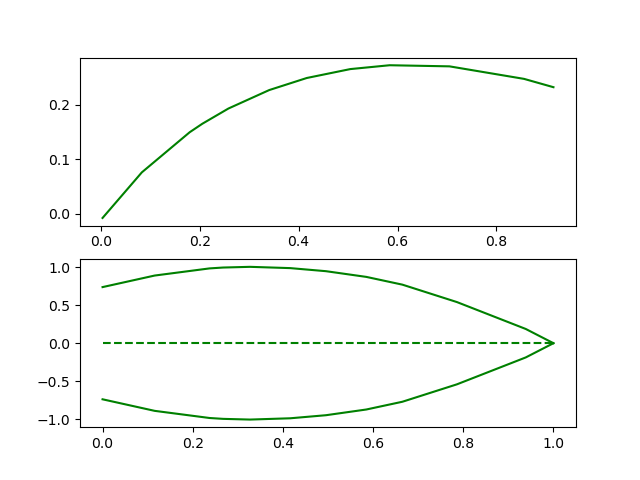

In [79]:
from heapq import *
from scipy.interpolate import splprep, splev
from scipy.integrate import simps, trapz
from openalea.plantgl.all import Vector3

from cereals_leaf import leaf_shape_perez, sr_prevot, parametric_leaf
# or
# from simple_maize import leaf_shape_perez, sr_prevot, parametric_leaf
# from fitting import leaf_shape_perez

from generator import curvilinear_abscisse

from fitting import fit2, fit3, simplify

from simplification import distance, cost


pl=parametric_leaf(nb_segment=10, insertion_angle=50, scurv=0.5, curvature=50, alpha=-2.3)

plt.figure()
plt.subplot(211)
plt.plot(pl[0], pl[1], c="green")
plt.subplot(212)
plt.plot(pl[2], pl[3], c="green")
plt.plot(pl[2], -pl[3], c="green")
plt.plot(np.arange(0,1.1,0.1), np.zeros(11), c="green", ls="dashed")
plt.show()

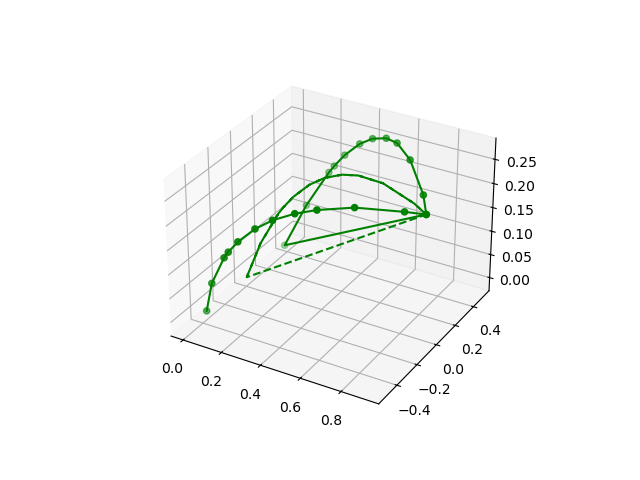

In [84]:
# Enable interactive plotting
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d
import matplotlib.tri as mtri

from fitting import leaf_to_mesh_2d

xy=pl[0:2]
r=pl[3]

pts,ind=leaf_to_mesh_2d(xy[0], xy[1], r)
# print(pts)
# print(ind)

xs=[]
ys=[]
zs=[]
for pt in pts:
    xs.append(pt[0])
    ys.append(pt[1])
    zs.append(pt[2])
    
# f=interp2d(xs, ys, zs, kind='cubic')
# surf=f(xs,ys)
X,Y=np.meshgrid(xs, ys)

tri = mtri.Triangulation(xs, ys)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, width_surface, cmap='viridis')
ax.scatter(xs,ys,zs,c="green")
ax.plot(xs,ys,zs,c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")
# ax.plot_surface(X, Y, surf, cmap='viridis')
# ax.plot_trisurf(xs, ys, zs, triangles=tri.triangles, color="green")
plt.show()


## 3. Generate leaf azimuth series

In [88]:
# from itertools import cycle

from plant_design import leaf_azimuth

nb_phy=10
leaf_azimuth(size=nb_phy, phyllotactic_angle=120, phyllotactic_deviation=15, plant_orientation=0, spiral=True)

array([  13.74756769,  113.56562005, -131.02936878,    9.09393196,
        114.29078921, -122.69576415,    7.16363557,  128.28040339,
       -132.21058821,    4.10424153])

## 4. Arrange a leaf to be placed along a stem with a given inclination.

In [89]:
from math import pi, cos, sin, radians
import openalea.plantgl.all as pgl

# from cereals_leaf import arrange_leaf
# or 
from geometry import arrange_leaf

arrange_leaf(leaf=pl, stem_diameter=0.5, inclination=1, relative=True)

(array([0.25318668, 0.3326695 , 0.42946334, 0.45509155, 0.50785566,
        0.59032535, 0.66640617, 0.75438866, 0.83409755, 0.95503526,
        1.10592672, 1.16543333]),
 array([-0.00816278,  0.07569901,  0.14949154,  0.16513309,  0.19312403,
         0.22704239,  0.24927316,  0.26563977,  0.2727323 ,  0.27067913,
         0.24764184,  0.23233597]),
 array([0.        , 0.11554358, 0.23725794, 0.26728231, 0.32701124,
        0.41618358, 0.49544578, 0.5849376 , 0.66496141, 0.78591655,
        0.93855649, 1.        ]),
 array([0.73865943, 0.89080462, 0.98489766, 0.99631893, 1.00556062,
        0.98875596, 0.94828555, 0.87311588, 0.77098497, 0.54159718,
        0.18741528, 0.        ]))

## 5. Build the whole plant shoot in 3D, as an MTG.

In [106]:
import openalea.plantgl.all as pgl
from openalea.mtg.turtle import TurtleFrame

from geometry import slim_cylinder, stem_mesh, _is_iterable, as_tuples, addSets, leaf_mesh, compute_element
# from cereals_leaf import leaf_mesh
from geometry import CerealsTurtle, CerealsVisitor

from fitting import leaf_element, leaf_to_mesh_2d, leaf_to_mesh, mesh4, plantgl_shape   # leaf_to_mesh_new ?


In [98]:
from openalea.mtg import MTG, fat_mtg
from scipy.interpolate import interp1d
import pandas

from plant_design import get_form_factor, blade_dimension, stem_dimension

from generator import majors_axes_regression, line_projection, as_leaf, as_plant, cereals as cereals_generator

from geometry import mtg_interpreter


In [75]:
def build_shoot(stem_radius, insertion_heights, leaf_lengths, leaf_areas, leaf_azimuths=None, leaf_shapes=None):
    """create a shoot

    Args:
        stem_radius: (float) the stem radius
        insertion_heights: list of each leaf insertion height
        leaf_lengths: list of each leaf length (blade length)
        leaf_areas: list of each blade area
        collar_visible: list of each collar height or True if the collar is visible and False if it is not
        leaf_shapes: list of each leaf shape, if it is not known write None
        leaf_azimuths: list of each leaf azimuth, if it is not known write None

    Returns:
        shoot: 

    """
    ranks = range(1, len(leaf_lengths) + 1)
    ntop = max(ranks) - np.array(ranks) + 1
    if leaf_shapes is None:
        a_leaf = parametric_leaf()
        leaf_shapes = [a_leaf for r in ranks]
    if leaf_azimuths is None:
        leaf_azimuths = leaf_azimuth(len(ranks))
    leaf_azimuths[1:] = np.diff(leaf_azimuths)
    ff = [get_form_factor(leaf) for leaf in leaf_shapes]
    blades = blade_dimension(area=leaf_areas, length=leaf_lengths, ntop=ntop)
    stem = stem_dimension(h_ins=insertion_heights, d_internode=np.array(stem_radius) * 2, ntop=ntop)
    df = blades.merge(stem)
    df['leaf_azimuth'] = leaf_azimuths
    df['leaf_rank'] = ranks
    df['leaf_shape'] = [leaf_shapes[n - 1] for n in df.leaf_rank]
    return df, cereals_generator(plant=df)

In [108]:
def geometric_dist(height=15, nb_phy=15, q=1):
    """ returns distances between individual leaves along a geometric model """

    if q == 1:
        u0 = float(height) / nb_phy
    else:
        u0 = height * (1. - q) / (1. - q ** (nb_phy + 1))

    return [u0 * q ** i for i in range(nb_phy)]

In [76]:
def build_shoot_w_pseudo(nb_phy, plant_height, insertion_heights, leaf_lengths, leaf_areas, 
                pseudostem_dist=1.4, stem_dist=1.2,
                diam_base=2.5, diam_top=1, pseudostem_height=20, 
                leaf_azimuths=None, leaf_shapes=None, wl=0.1):
    """create a shoot, with pseudostems and stems

    Args:
        stem_radius: (float) the stem radius
        insertion_heights: list of each leaf insertion height
        leaf_lengths: list of each leaf length (blade length)
        leaf_areas: list of each blade area
        collar_visible: list of each collar height or True if the collar is visible and False if it is not
        leaf_shapes: list of each leaf shape, if it is not known write None
        leaf_azimuths: list of each leaf azimuth, if it is not known write None

    Returns:
        shoot: 

    """
    ranks = range(1, len(leaf_lengths) + 1)
    ntop = max(ranks) - np.array(ranks) + 1

    nb_phy = int(nb_phy)

    # Lejeune an Bernier formula + col =
    nb_young_phy = int(round((nb_phy - 1.95) / 1.84 / 1.3))

    # distances between leaves
    pseudostem = geometric_dist(pseudostem_height, nb_young_phy,
                                pseudostem_dist)
    stem = geometric_dist(plant_height - pseudostem_height,
                          nb_phy - nb_young_phy, stem_dist)
    internode = pseudostem + stem
    # stem diameters
    diameter = ([diam_base] * nb_young_phy +
                np.linspace(diam_base, diam_top,
                            nb_phy - nb_young_phy).tolist())
    
    if leaf_shapes is None:
        a_leaf = parametric_leaf()
        leaf_shapes = [a_leaf for r in ranks]
    if leaf_azimuths is None:
        leaf_azimuths = leaf_azimuth(len(ranks))
    leaf_azimuths[1:] = np.diff(leaf_azimuths)
    ff = [get_form_factor(leaf) for leaf in leaf_shapes]
    # blades = blade_dimension(area=leaf_areas, length=leaf_lengths, ntop=ntop)
    blades = blade_dimension(length=leaf_lengths, form_factor=ff, ntop=ntop, wl=wl)
    # stem = stem_dimension(h_ins=insertion_heights, d_internode=diameter, ntop=ntop)
    stem = stem_dimension(internode=internode, d_internode=diameter, ntop=ntop)
    
    df = blades.merge(stem)
    df['leaf_azimuth'] = leaf_azimuths
    df['leaf_rank'] = ranks
    df['leaf_shape'] = [leaf_shapes[n - 1] for n in df.leaf_rank]
    return df, cereals_generator(plant=df)

# shoot, g = build_shoot(3.0, [2,4,6,8], [2,4,6,8], [2,4,6,8])
# scene, nump = build_scene(g)
# display_scene(scene)

## 6. Display scenes according to different scenarii

In [77]:
def bell_shaped_dist(plant_area=1, nb_phy=15, rmax=.7, skew=0.15):
    """ returns leaf area of individual leaves along bell shaped model """

    k = -np.log(skew) * rmax
    r = np.linspace(1. / nb_phy, 1, nb_phy)
    relative_surface = np.exp(-k / rmax * (2 * (r - rmax) ** 2 + (r - rmax) ** 3))
    leaf_area = relative_surface / relative_surface.sum() * plant_area
    return leaf_area.tolist()

### A single cereal

In [99]:
from display import display_mtg, build_scene, display_scene

%gui qt

# generation of a 3D plant from descritive parameters
stem_radius=0.5 # realistic, number or growing with phytomer age ?
height=2000 # from crop model
nb_phy=15 # from 0 to fixed max nb of phytomers
max_leaf_length=2000
insertion_angle=50
scurv=0.5
curvature=50
phyllotactic_angle=120
spiral=True

insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) # further separate stem and pseudo stem, cf simple maize

leaf_lengths=np.array(bell_shaped_dist(plant_area=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) # plant area --> max leaf length
# leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension

a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
leaf_shapes = [a_leaf for l in leaf_lengths] # replace leaf_length by nb_phy or...

leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)

# shoot, g = build_shoot_w_pseudo(nb_phy=nb_phy, plant_height=height, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None, 
#                 pseudostem_dist=1.4, stem_dist=1.,
#                 diam_base=2.5, diam_top=1, pseudostem_height=20, 
#                 leaf_azimuths=None, leaf_shapes=None)

shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None,
                leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

print(g)

scene, nump = build_scene(g)
display_scene(scene)

MTG : nb_vertices=32, nb_scales=2


In [111]:
from simple_maize import simple_maize

pl = parametric_leaf()
pl_dict = {rank: pl for rank in range(1, 17)}

# simple_maize(leaves=pl_dict,seed=1)

### A cereal crop with variability

In [15]:
from stand import agronomic_plot
from display import display_mtg, build_scene, display_scene
from random import *
# from oawidgets.plantgl import *
# from oawidgets.mtg import *

%gui qt

seed(1)

# generation of a crop of 3D plants from descritive parameters with variability
plants_in_crop=[]
length_plot=10
width_plot=10
sowing_density=10
plant_density=2
inter_row=2
nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, width_plot, sowing_density, plant_density, inter_row, noise=0.1)

for n in range(nplants):
    stem_radius=0.5 # realistic, number or growing with phytomer age ?
    height=2000*(1+random()-0.5) # from crop model
    nb_phy=15 # from 0 to fixed max nb of phytomers
    max_leaf_length=2000*(1+random()-0.5)
    insertion_angle=50*(1+random()-0.5)
    scurv=0.5*(1+random()-0.5)
    curvature=50*(1+random()-0.5)
    phyllotactic_angle=120*(1+random()-0.5)
    spiral=True
    
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) # further separate stem and pseudo stem, cf simple maize
    
    leaf_lengths=np.array(bell_shaped_dist(plant_area=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) # plant area --> max leaf length
    # leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension
    
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths] # replace leaf_length by nb_phy or...
    
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)
    
    # shoot, g = build_shoot_w_pseudo(nb_phy=nb_phy, plant_height=height, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None, 
    #                 pseudostem_dist=1.4, stem_dist=1.,
    #                 diam_base=2.5, diam_top=1, pseudostem_height=20, 
    #                 leaf_azimuths=None, leaf_shapes=None)
    shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None,
                    leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

    plants_in_crop.append(g)


scene, nump = build_scene(plants_in_crop, positions)
display_scene(scene)
# PlantGL(scene)

### A seemingly growing plant

In [104]:
from stand import agronomic_plot
from display import display_mtg, build_scene, display_scene
from random import *
from openalea.plantgl.all import *
# from oawidgets.plantgl import *
# from oawidgets.mtg import *

%gui qt

seed(1)

# generation of ""growing"" 3D plants from descritive parameters
plants_in_crop=[]
length_plot=1
width_plot=1
sowing_density=10
plant_density=10
inter_row=0.75
# nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, width_plot, sowing_density, plant_density, inter_row, noise=0.1)
nplants=10
positions=[(x,0,0) for x in range(-50, 50, 10)]
final_height=2000
final_nb_phy=2*nplants
heights=geometric_dist(final_height, final_nb_phy, 1.2)
# insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2))

for n in range(1,nplants+1):
    stem_radius=0.5 # realistic, number or growing with phytomer age ?
    height=heights[2*n-1] # from crop model
    nb_phy=2*n # from 0 to fixed max nb of phytomers
    max_leaf_length=10*2*n
    insertion_angle=50
    scurv=0.5
    curvature=50
    phyllotactic_angle=120
    spiral=True
    
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) # further separate stem and pseudo stem, cf simple maize
    
    leaf_lengths=np.array(bell_shaped_dist(plant_area=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) # plant area --> max leaf length
    # leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension
    # print(leaf_lengths)
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths] # replace leaf_length by nb_phy or...

    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)

    # shoot, g = build_shoot_w_pseudo(nb_phy=nb_phy, plant_height=height, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None, 
    #                 pseudostem_dist=1.4, stem_dist=1.,
    #                 diam_base=2.5, diam_top=1, pseudostem_height=20, 
    #                 leaf_azimuths=None, leaf_shapes=None)
    shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None,
                    leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

    print(g)

    plants_in_crop.append(g)


scene, nump = build_scene(plants_in_crop[2:], positions[2:], leaf_material=Material(Color3((50,100,0))), stem_material=Material(Color3((50,100,0))))
display_scene(scene)
# PlantGL(scene)

MTG : nb_vertices=6, nb_scales=2
MTG : nb_vertices=10, nb_scales=2
MTG : nb_vertices=14, nb_scales=2
MTG : nb_vertices=18, nb_scales=2
MTG : nb_vertices=22, nb_scales=2
MTG : nb_vertices=26, nb_scales=2
MTG : nb_vertices=30, nb_scales=2
MTG : nb_vertices=34, nb_scales=2
MTG : nb_vertices=38, nb_scales=2
MTG : nb_vertices=42, nb_scales=2


### An intercrop organized in rows

In [103]:
from stand import agronomic_plot
from display import display_mtg, build_scene, display_scene
from random import *
# from oawidgets.plantgl import *
# from oawidgets.mtg import *
from openalea.plantgl.all import Material, Color3, Shape, Scene, Viewer, Translated, AxisRotated

%gui qt

seed(1)

# generation of 3D intercropped plants from descritive parameters
# plants_in_crop=[]
# length_plot=1
# width_plot=1
# sowing_density=10
# plant_density=10
# inter_row=0.75
# nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, width_plot, sowing_density, plant_density, inter_row, noise=0.1)
# nplants=10

# final_height=2000
# final_nb_phy=2*nplants
# heights=geometric_dist(final_height, final_nb_phy, 1.2)
# insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2))
def plant(height, nb_phy, max_leaf_length, phyllotactic_angle, spiral):
    stem_radius=0.5 # realistic, number or growing with phytomer age ?
    insertion_angle=50
    scurv=0.7
    curvature=100
    
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) # further separate stem and pseudo stem, cf simple maize
    
    leaf_lengths=np.array(bell_shaped_dist(plant_area=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) # plant area --> max leaf length
    # leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension
    
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths] # replace leaf_length by nb_phy or...
    
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)

    # shoot, g = build_shoot_w_pseudo(nb_phy=nb_phy, plant_height=height, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None, 
    #                 pseudostem_dist=1.4, stem_dist=1.,
    #                 diam_base=2.5, diam_top=1, pseudostem_height=20, 
    #                 leaf_azimuths=None, leaf_shapes=None)
    shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None,
                    leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

    return g


### Mixture organized in alternate rows

n_rows = 10
len_rows = 10

d_inter = 70
d_intra = 40

def plant_in_row(i):
     if i%(4*d_inter)==0 or i%(4*d_inter)==d_inter: return plant(height=1500, nb_phy=12, max_leaf_length=800, phyllotactic_angle=120, spiral=True)
     else: return plant(height=800, nb_phy=10, max_leaf_length=400, phyllotactic_angle=120, spiral=True)

# ms=[]

# for x in range(0, n_rows*d_inter, d_inter):
#     for y in range(0, len_rows*d_intra, d_intra):
#         g, col=plant_in_row(x)
#         ts=Translated((x,y,0), g)
#         sh=Shape(ts, col)

#         ms.append(sh)

# scene=Scene(ms)

# Viewer.display(scene)

plants_in_crop = [plant_in_row(x) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

positions=[(x,y,0) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

scene, nump = build_scene(plants_in_crop, positions, leaf_material=Material(Color3((50,100,0))), stem_material=Material(Color3((50,100,0))))
display_scene(scene)
# PlantGL(scene)

## 7. Tillering / Branching

In [ ]:
def build_shoot_w_tillers(stem_radius, insertion_heights, leaf_lengths, leaf_areas, leaf_azimuths=None, leaf_shapes=None):
    """create a shoot with tillers

    Args:
        stem_radius: (float) the stem radius
        insertion_heights: list of each leaf insertion height
        leaf_lengths: list of each leaf length (blade length)
        leaf_areas: list of each blade area
        collar_visible: list of each collar height or True if the collar is visible and False if it is not
        leaf_shapes: list of each leaf shape, if it is not known write None
        leaf_azimuths: list of each leaf azimuth, if it is not known write None

    Returns:
        shoot: 

    """
    ranks = range(1, len(leaf_lengths) + 1)
    ntop = max(ranks) - np.array(ranks) + 1
    if leaf_shapes is None:
        a_leaf = parametric_leaf()
        leaf_shapes = [a_leaf for r in ranks]
    if leaf_azimuths is None:
        leaf_azimuths = leaf_azimuth(len(ranks))
    leaf_azimuths[1:] = np.diff(leaf_azimuths)
    ff = [get_form_factor(leaf) for leaf in leaf_shapes]
    blades = blade_dimension(area=leaf_areas, length=leaf_lengths, ntop=ntop)
    stem = stem_dimension(h_ins=insertion_heights, d_internode=np.array(stem_radius) * 2, ntop=ntop)
    df = blades.merge(stem)
    df['leaf_azimuth'] = leaf_azimuths
    df['leaf_rank'] = ranks
    df['leaf_shape'] = [leaf_shapes[n - 1] for n in df.leaf_rank]
    return df, cereals_generator(plant=df)

In [ ]:
from display import display_mtg, build_scene, display_scene

%gui qt

# generation of a 3D plant from descritive parameters
stem_radius=0.5 # realistic, number or growing with phytomer age ?
height=2000 # from crop model
nb_phy=15 # from 0 to fixed max nb of phytomers
max_leaf_length=2000
insertion_angle=50
scurv=0.5
curvature=50
phyllotactic_angle=120
spiral=True

insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) # further separate stem and pseudo stem, cf simple maize

leaf_lengths=np.array(bell_shaped_dist(plant_area=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) # plant area --> max leaf length
# leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension

a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
leaf_shapes = [a_leaf for l in leaf_lengths] # replace leaf_length by nb_phy or...

leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)

# shoot, g = build_shoot_w_pseudo(nb_phy=nb_phy, plant_height=height, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None, 
#                 pseudostem_dist=1.4, stem_dist=1.,
#                 diam_base=2.5, diam_top=1, pseudostem_height=20, 
#                 leaf_azimuths=None, leaf_shapes=None)

shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, leaf_areas=None,
                leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

print(g)

scene, nump = build_scene(g)
display_scene(scene)

## 8. Light interception with Caribu

In [112]:
from alinea.caribu.CaribuScene import CaribuScene

ModuleNotFoundError: No module named 'alinea.caribu'

## Next steps:
- Dynamic FSPM : appearance and elongation of phytomers (internodes and leaves)
- Constrains from crop model
- Adapt for different species (parameters for cereals, some functions for legumes)